In [1]:
#!pip install torchxrayvision

import os,sys
sys.path.insert(0,"..")
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import sys
import torch.nn.functional as F
import tqdm
import sklearn, sklearn.metrics
import pandas as pd
import torchxrayvision as xrv
import skimage

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# NIH Data
# !mkdir capstone
# !cp /content/gdrive/MyDrive/Capstone/images_001.tar.gz /content/capstone/images

# !tar -xf /content/gdrive/MyDrive/capstone/images-224.tar -C /content/capstone

cp: cannot stat '/content/gdrive/MyDrive/Capstone/images_001.tar.gz': No such file or directory


In [ ]:
# %%time
# !cp /content/gdrive/MyDrive/capstone/CheXpert-v1.0-small.zip /content/
# !mkdir CheXpert
# !unzip -q CheXpert-v1.0-small.zip -d /content/CheXpert/

CPU times: user 2.41 s, sys: 341 ms, total: 2.75 s
Wall time: 5min 35s


In [ ]:
# !ls /content/CheXpert/CheXpert-v1.0-small/train/patient12852/study1/view1_frontal.jpg
# !ls /content/CheXpert/CheXpert-v1.0-small/train/patient49183/study2/view1_frontal.jpg


/content/CheXpert/CheXpert-v1.0-small/train/patient49183/study2/view1_frontal.jpg


Shape: (320, 390)


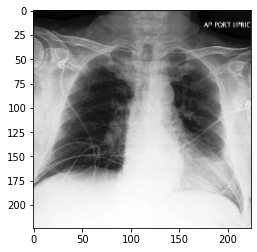

In [12]:
colab = False
dataset_path = "/content/CheXpert/" if colab else "."
img_path = f"{dataset_path}/CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg"
chexpert_img = skimage.io.imread(img_path)

print(f"Shape: {chexpert_img.shape}")
plt.imshow(chexpert_img, cmap="Greys_r")
plt_img_before = np.copy(chexpert_img)

def normalize_img(img):
    chexpert_img = xrv.datasets.normalize(img, 255)
    chexpert_img = chexpert_img[None, :, :]
    transform = torchvision.transforms.Compose([
        xrv.datasets.XRayCenterCrop(),
        xrv.datasets.XRayResizer(224),
    ])
    chexpert_img = transform(chexpert_img)
    chexpert_img = torch.from_numpy(chexpert_img).unsqueeze(0)
    return chexpert_img

chexpert_img = normalize_img(chexpert_img)
plt.imshow(chexpert_img[0, 0], cmap="Greys_r")

(1, 1, 224, 224)


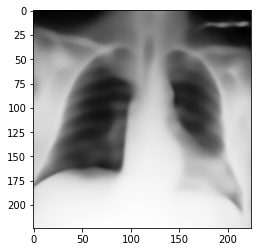

In [4]:
ae = xrv.autoencoders.ResNetAE(weights="101-elastic")
#out = ae(chexpert_img)
z = ae.encode(chexpert_img)
decoded = ae.decode(z).detach().numpy()
#img_r = out['out'].detach().numpy()
print(decoded.shape)
plt.imshow(decoded[0][0], cmap="Greys_r")

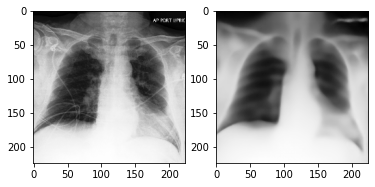

In [8]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(chexpert_img[0, 0], cmap='Greys_r')
ax[1].imshow(decoded[0][0], cmap='Greys_r')

In [37]:
classifier = xrv.models.DenseNet(weights="all")

If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /home/florian/.torchxrayvision/models_data/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]


In [38]:
classifier(chexpert_img)

tensor([[0.7057, 0.5344, 0.5128, 0.5053, 0.5612, 0.5023, 0.5090, 0.5626, 0.5304,
         0.4753, 0.6446, 0.5011, 0.5146, 0.7185, 0.5346, 0.5741, 0.6772, 0.5260]],
       grad_fn=<IndexPutBackward0>)

Changing label 0 from 0.7056549787521362 to 0.0
   0 Loss: 14237.0215 | Loss reconstruction: 6027.3340 | Loss classification: 8209.6875
   1 Loss: 13940.3213 | Loss reconstruction: 5741.8125 | Loss classification: 8198.5088
   2 Loss: 13835.5391 | Loss reconstruction: 5643.0640 | Loss classification: 8192.4756
   3 Loss: 13779.4062 | Loss reconstruction: 5588.9507 | Loss classification: 8190.4551
   4 Loss: 13736.2266 | Loss reconstruction: 5547.2505 | Loss classification: 8188.9766
   5 Loss: 13706.1992 | Loss reconstruction: 5518.1748 | Loss classification: 8188.0244
   6 Loss: 13681.0840 | Loss reconstruction: 5493.6338 | Loss classification: 8187.4502
   7 Loss: 13653.9863 | Loss reconstruction: 5467.0049 | Loss classification: 8186.9819
   8 Loss: 13629.1475 | Loss reconstruction: 5442.5640 | Loss classification: 8186.5835
   9 Loss: 13608.2832 | Loss reconstruction: 5422.0547 | Loss classification: 8186.2290
  10 Loss: 13589.9629 | Loss reconstruction: 5403.9731 | Loss classifica

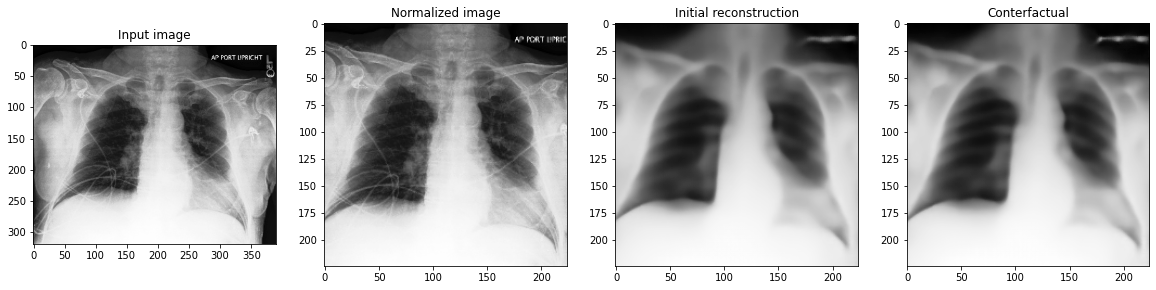

In [42]:
def find_counterfactual(input_img, target_labels, target_weight=300):
    z_init = ae.encode(input_img)
    # optimize z
    z = z_init.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([z], lr=0.03)
    for i in range(30):
        optimizer.zero_grad()
        img_r = ae.decode(z)
        loss_reconstruction = F.mse_loss(img_r, input_img)
        classification_label = classifier(img_r)
        loss_classification = F.cross_entropy(classification_label, target_labels)*target_weight

        loss = loss_reconstruction + loss_classification
        print(f"{i:4} Loss: {loss.item():.4f} | Loss reconstruction: {loss_reconstruction.item():.4f} | Loss classification: {loss_classification.item():.4f}")
        loss.backward()
        optimizer.step()

    # output image
    img_r_init = ae.decode(z_init).detach().numpy()
    img_r = ae.decode(z).detach().numpy()
    return img_r_init, img_r


img_path = f"{dataset_path}/CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg"
input_img_raw = skimage.io.imread(img_path)
input_img = normalize_img(input_img_raw)

input_labels = classifier(input_img)
feature_index = 0 # 0: ?
# flip label
target_labels = input_labels.clone().detach()
target_labels[0, feature_index] = 0
print(f"Changing label {feature_index} from {input_labels[0, feature_index]} to {target_labels[0, feature_index]}")

img_r_init, img_r = find_counterfactual(input_img, target_labels)
fig, ax = plt.subplots(1,4, figsize=(20,10))
ax[0].imshow(input_img_raw, cmap='Greys_r');    ax[0].set_title("Input image");
ax[1].imshow(input_img[0][0], cmap='Greys_r');  ax[1].set_title("Normalized image");
ax[2].imshow(img_r_init[0][0], cmap='Greys_r'); ax[2].set_title("Initial reconstruction");
ax[3].imshow(img_r[0][0], cmap='Greys_r');      ax[3].set_title("Conterfactual");